Test code to compare quantification accuracy when including additional incomplete isoforms



In [1]:
import glob

import pandas as pd
import numpy as np

%load_ext rpy2.ipython

In [2]:
truth_t_infile = '../../run/annotations/mixture_concentrations.tsv'

In [3]:
number_reads = 500000
truth_t = pd.read_table(truth_t_infile, sep='\t', index_col=0)
truth_t.columns = ['Length', 'MXA', 'MXB']
print(truth_t.head())

truth_g = truth_t.copy()
truth_g = truth_g[['MXA', 'MXB']]


print(truth_t.head())


truth_g['gene_id'] = ["_".join(x.split("_")[0:2]) for x in truth_g.index]
truth_g = pd.DataFrame(truth_g.groupby('gene_id').sum())
truth_g.index.name = 'ID'
print(truth_g.head(10))


truth_t2 = truth_t.copy()
truth_t2.columns = ['Length', 'transcript_truth', 'transcript_truthMXB']
print(truth_t2.head(10))

truth_g2 = truth_g.copy()
truth_g2.columns = ['gene_truth', 'gene_truthMXB']
print(truth_g2.head(10))

print(sum(truth_t['MXA']))
print(sum(truth_t2['transcript_truth']))
print(sum(truth_g2['gene_truth']))

          Length          MXA          MXB
ID                                        
R1_11_1      703   161.132812     5.035400
R1_11_2      785    80.566406    10.070801
R1_13_1     1940  5156.250000  2578.125000
R1_13_2      698  2578.125000  5156.250000
R1_101_1     719    10.070801     1.258850
          Length          MXA          MXB
ID                                        
R1_11_1      703   161.132812     5.035400
R1_11_2      785    80.566406    10.070801
R1_13_1     1940  5156.250000  2578.125000
R1_13_2      698  2578.125000  5156.250000
R1_101_1     719    10.070801     1.258850
                 MXA           MXB
ID                                
R1_101     15.106201      1.888275
R1_102     15.106201      0.944138
R1_103    966.796875    483.398438
R1_11     241.699219     15.106201
R1_12      30.212402     60.424805
R1_13    7734.375000   7734.375000
R1_14     483.398438    241.699219
R1_21   30937.500000  30937.500000
R1_22     483.398438     30.212402
R1_23      15

In [4]:
incomplete_t_infiles = glob.glob('../../run/*/add_models/incomplete/*_neat-A_subset/quant.sf')
incomplete_t_infiles.extend(glob.glob('../../run/*/add_models/incomplete/*_neat-A_subset/abundance.h5.tsv'))
#skip_exon_g_infiles = glob.glob('../../run/*/add_models/skip_exons/*/genes.tsv.gz')

In [5]:
final_t_df = pd.DataFrame()

for infile in incomplete_t_infiles:
    parameters = infile.split("/")[-2]
    
    fraction = parameters.split("_")[0]
    iteration = parameters.split("_")[1]
    
    quantifier = infile.split("/")[-5].split(".")[0]
    
    tmp_df = pd.read_table(infile, sep="\t", index_col=0)
    
    if quantifier == 'kallisto':
        tmp_df.columns=['Length', 'EffectiveLength', 'NumReads', 'TPM']
    else:
        tmp_df.columns=['Length', 'EffectiveLength', 'TPM', 'NumReads']
        
    tmp_df = pd.merge(tmp_df, truth_t, left_index=True, right_index=True, how='left')

    tmp_df.fillna(0, inplace=True)
    tmp_df['fraction'] = fraction
    tmp_df['quantifier'] = quantifier
    tmp_df['iteration'] = iteration

    # need to merge in info from info infile
    info_infile = '../../run/sequins/add_models/incomplete/transcripts_%s_%s.gtf.gz.tsv' % (
        fraction, iteration)
    info_df = pd.read_table(info_infile, sep='\t', index_col=0)    
    info_df['fraction_exons_covered'] = (info_df['end'] /  (info_df['start'] -1)) / info_df['exons']
    
    tmp_df = pd.merge(tmp_df, info_df, left_index=True, right_index=True, how='left')
    
    tmp_df['incomplete_model'] = [1 if 'incomplete' in x else 0 for x in tmp_df.index]
    tmp_df['t_id'] = ["_".join(x.split("_")[0:3]) for x in tmp_df.index]
    tmp_df['g_id'] = ["_".join(x.split("_")[0:2]) for x in tmp_df.index]
    
    # need to make temp transcript and gene-level truth dataframes to
    # convert concentration to counts
    
    tmp_truth_t2 = truth_t2.copy()
    tmp_truth_g2 = truth_g2.copy()
    
    number_reads = sum(tmp_df['NumReads'])    
    tmp_df['MXA'] = (tmp_df['MXA'] / sum(tmp_df['MXA'])) * number_reads
    
    tmp_truth_t2['transcript_truth'] = (tmp_truth_t2['transcript_truth'] /
                                  sum(tmp_truth_t2['transcript_truth'])) * number_reads
    tmp_truth_g2['gene_truth'] = (tmp_truth_g2['gene_truth'] / 
                                  sum(tmp_truth_g2['gene_truth'])) * number_reads
    
    tmp_df = pd.merge(tmp_df, tmp_truth_t2, left_on='t_id', right_index=True, how='left')
    tmp_df = pd.merge(tmp_df, tmp_truth_g2, left_on='g_id', right_index=True, how='left')

    t_count_incomplete = pd.DataFrame(tmp_df.groupby('t_id')['incomplete_model'].sum())
    t_count_incomplete.columns = ['count_incomplete_t']
    
    g_count_incomplete = pd.DataFrame(tmp_df.groupby('g_id')['incomplete_model'].sum())
    g_count_incomplete.columns = ['count_incomplete_g']
    
    tmp_df = pd.merge(tmp_df, t_count_incomplete, left_on='t_id', right_index=True)
    tmp_df = pd.merge(tmp_df, g_count_incomplete, left_on='g_id', right_index=True)
    tmp_df['t_incomplete'] = tmp_df['count_incomplete_t'] > 0
    tmp_df['g_incomplete'] = tmp_df['count_incomplete_g'] > 0
    
    kmers_infile = '../../run/sequins/add_models/incomplete/transcripts_%s_%s_transcript_kmers.tsv' % (
    fraction, iteration)

    kmers_df = pd.read_table(kmers_infile, sep='\t', index_col=0)
    tmp_df = pd.merge(tmp_df, kmers_df, left_index=True, right_index=True)

    final_t_df = pd.concat((final_t_df, tmp_df))


final_t_df['id'] = final_t_df.index

final_t_df['difference'] = np.log10(final_t_df['NumReads']+1) - np.log10(final_t_df['MXA']+1)

final_t_df['absolute_difference'] = abs(final_t_df['difference'])

final_t_df['relative_absolute_difference'] = final_t_df['absolute_difference'] / np.log10(final_t_df['MXA'] +1)

print(final_t_df.shape)


(122280, 33)


In [6]:
print(final_t_df.shape)
final_t_df = final_t_df[~final_t_df['g_id'].isin(['R1_11', 'R1_21', 'R2_14', 'R2_26'])]
print(final_t_df.shape)

(122280, 33)
(117663, 33)


In [7]:
print(set(final_t_df['quantifier']))

{'kallisto', 'salmon', 'sailfish'}


In [8]:
%%R -i final_t_df

library(ggplot2)

print(head(final_t_df))

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: Find out what's changed in ggplot2 at
http://github.com/tidyverse/ggplot2/releases.

  warnings.warn(x, RRuntimeWarning)


  EffectiveLength Length Length_x Length_y        MXA         MXB  NumReads
1         551.136    719      719      719  51.660012   1.2588501  23.73350
2         262.750    430      430      430  25.830006   0.6294250   8.26649
3        1322.140   1490     1490     1490   4.558236   0.8886001   6.66649
4        1194.140   1362     1362     1362  72.931781   0.0555375  93.33350
5        1586.140   1754     1754     1754 551.040125 429.6875000 814.00300
6         522.136   1754      690        0   0.000000   0.0000000   0.00000
        TPM count_incomplete_g count_incomplete_t end exons fraction
1  31.79910                  0                  0   3     3      0.1
2  23.23210                  0                  0   2     2      0.1
3   3.72333                  0                  0   7     7      0.1
4  57.71580                  0                  0   6     6      0.1
5 378.96300                  1                  1  15    15      0.1
6   0.00000                  1                  1  12 

In [9]:
%%R
print(head(final_t_df[is.na(final_t_df$bin_expression),]))

 [1] EffectiveLength              Length                      
 [3] Length_x                     Length_y                    
 [5] MXA                          MXB                         
 [7] NumReads                     TPM                         
 [9] count_incomplete_g           count_incomplete_t          
[11] end                          exons                       
[13] fraction                     fraction_exons_covered      
[15] fraction_unique              g_id                        
[17] g_incomplete                 gene_truth                  
[19] gene_truthMXB                incomplete_model            
[21] iteration                    non_unique_kmers            
[23] quantifier                   start                       
[25] t_id                         t_incomplete                
[27] transcript_truth             transcript_truthMXB         
[29] unique_kmers                 id                          
[31] difference                   absolute_difference  

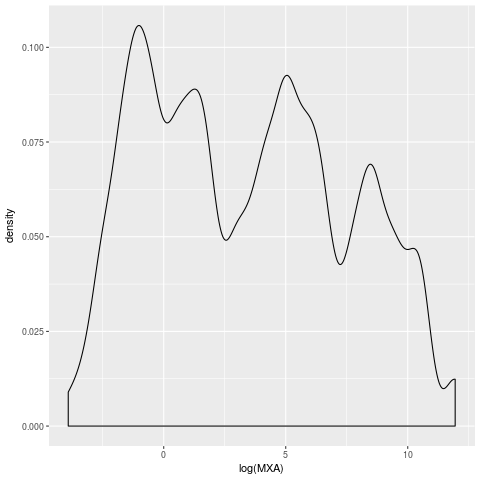

In [10]:
%%R
p = ggplot(final_t_df, aes(log(MXA))) + geom_density()
print(p)

In [11]:
%%R
print(head(final_t_df, 2))

  EffectiveLength Length Length_x Length_y      MXA      MXB NumReads     TPM
1         551.136    719      719      719 51.66001 1.258850 23.73350 31.7991
2         262.750    430      430      430 25.83001 0.629425  8.26649 23.2321
  count_incomplete_g count_incomplete_t end exons fraction
1                  0                  0   3     3      0.1
2                  0                  0   2     2      0.1
  fraction_exons_covered fraction_unique   g_id g_incomplete gene_truth
1                    Inf       0.7979651 R1_101        FALSE   77.49002
2                    Inf       0.6516291 R1_101        FALSE   77.49002
  gene_truthMXB incomplete_model iteration non_unique_kmers quantifier start
1      1.888275                0         0              139   sailfish     1
2      1.888275                0         0              139   sailfish     1
      t_id t_incomplete transcript_truth transcript_truthMXB unique_kmers
1 R1_101_1        FALSE         51.66001            1.258850        

In [12]:
%%R
final_t_df['bin_fraction_unique'] = .bincode(include.lowest = TRUE,
    final_t_df[['fraction_unique']], breaks=seq(0,1.1,0.1))

final_t_df['bin_small_fraction_unique'] = .bincode(include.lowest = TRUE,
    final_t_df[['fraction_unique']], breaks=seq(0,1.1,0.02))

subsetted_final_t_df = final_t_df[(final_t_df['incomplete_model']==F & final_t_df['count_incomplete_t']<=5),]
subsetted2_final_t_df = final_t_df[(final_t_df['incomplete_model']==T & final_t_df['count_incomplete_t']<=5),]


/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: No summary function supplied, defaulting to `mean_se()

  warnings.warn(x, RRuntimeWarning)


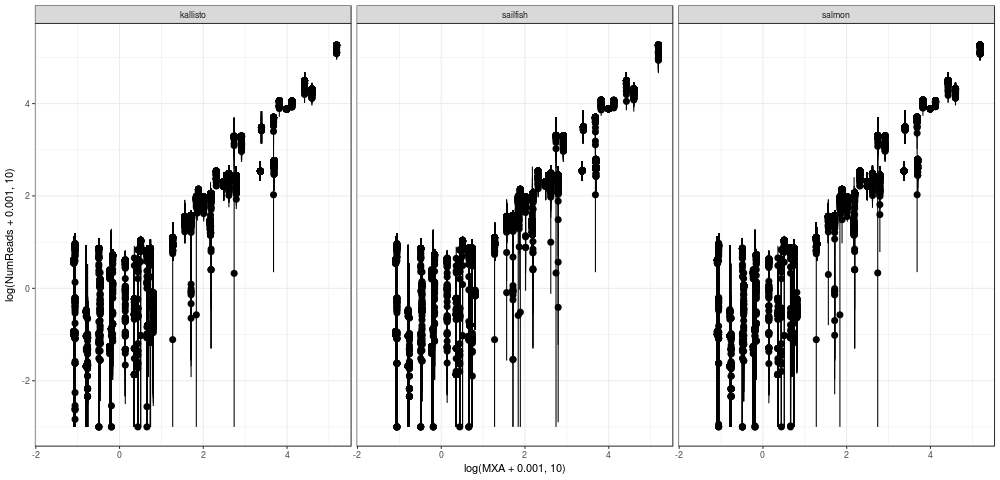

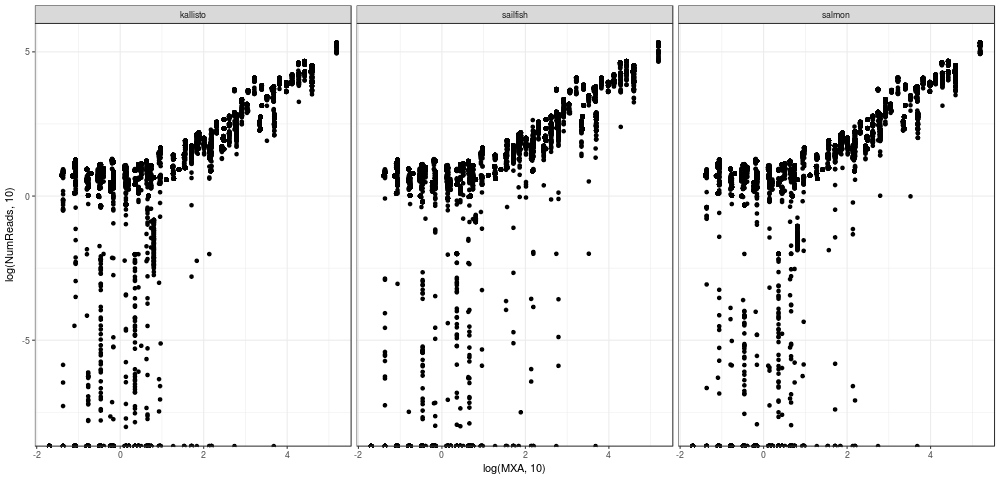

In [13]:
%%R -w 1000

p = ggplot(subsetted_final_t_df, aes(log(MXA+0.001,10), log(NumReads+0.001,10))) +
stat_summary() +
theme_bw() + facet_wrap(~quantifier)
print(p)

p = ggplot(subsetted_final_t_df, aes(log(MXA,10), log(NumReads,10))) + geom_point() +
theme_bw() + facet_wrap(~quantifier)
print(p)

In [14]:
%%R
print(log(2.52,10))

[1] 0.4014005


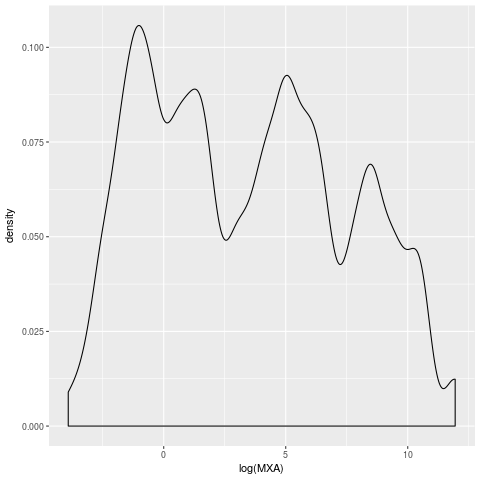

In [15]:
%%R
p = ggplot(final_t_df, aes(log(MXA))) + geom_density()
print(p)

/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: No summary function supplied, defaulting to `mean_se()

  warnings.warn(x, RRuntimeWarning)
/home/FILESERVER5/proteomics/tss38/anaconda3/lib/python3.5/site-packages/rpy2/rinterface/__init__.py:186: RRuntimeWarning: geom_path: Each group consists of only one observation. Do you need to adjust
the group aesthetic?

  warnings.warn(x, RRuntimeWarning)


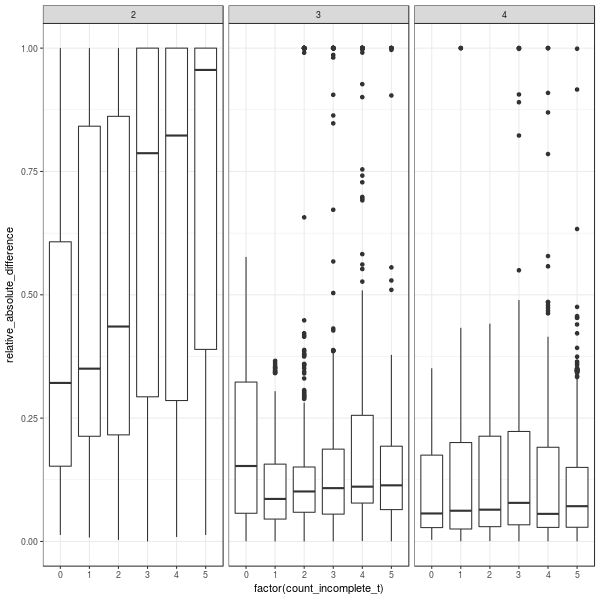

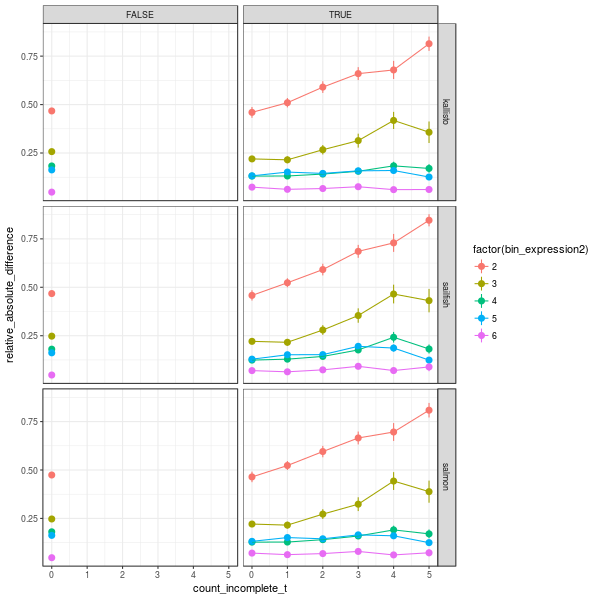

In [16]:


%%R -w 600 -h 600
subsetted_final_t_df['bin_expression1'] = .bincode(
    log(subsetted_final_t_df[['MXA']]), breaks=c(-10,0.5,3,5.5,100))

p = ggplot(subsetted_final_t_df[subsetted_final_t_df['bin_expression1']>1,],
           aes(factor(count_incomplete_t), relative_absolute_difference)) +
geom_boxplot() +
facet_wrap(~bin_expression1) +
theme_bw()

print(p)

subsetted_final_t_df['bin_expression2'] = .bincode(
    log(subsetted_final_t_df[['MXA']]), breaks=c(-10,0.5,2,4,6,8,100))

p = ggplot(subsetted_final_t_df[subsetted_final_t_df['bin_expression2']>1,],
           aes(count_incomplete_t, relative_absolute_difference)) +
stat_summary(aes(colour = factor(bin_expression2))) +
stat_summary(fun.y = mean, geom="line", aes(colour = factor(bin_expression2))) +
facet_grid(quantifier~g_incomplete) +
theme_bw()

print(p)




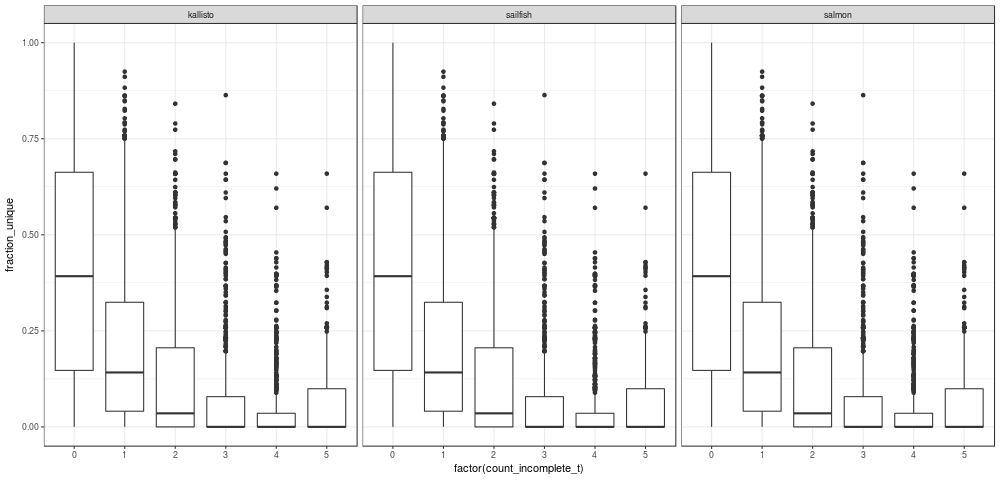

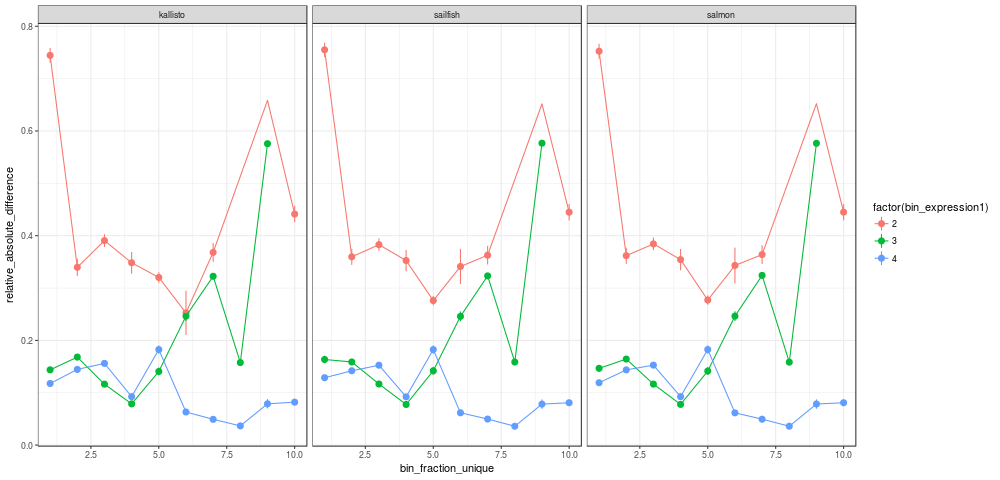

In [17]:
%%R -w 1000


p = ggplot(subsetted_final_t_df, aes(factor(count_incomplete_t), fraction_unique)) +
geom_boxplot() +
theme_bw() +
facet_grid(.~quantifier)

print(p)

p = ggplot(subsetted_final_t_df[subsetted_final_t_df['bin_expression1']>1,],
           aes(bin_fraction_unique, relative_absolute_difference)) +
stat_summary(aes(colour = factor(bin_expression1))) +
stat_summary(fun.y = mean, geom="line", aes(colour = factor(bin_expression1))) +
theme_bw() +
facet_grid(.~quantifier)

print(p)

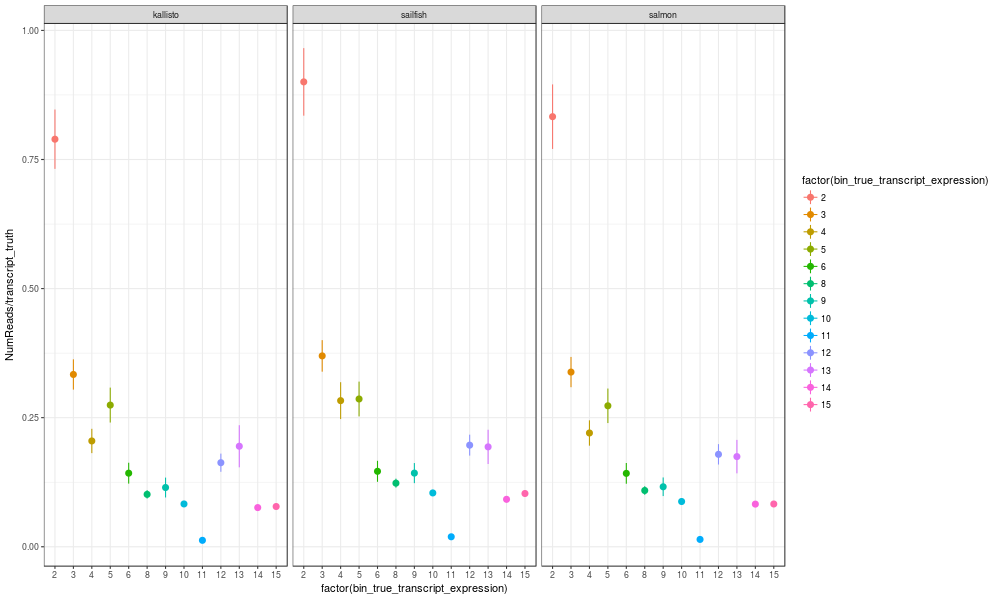

In [43]:
%%R -w 1000 -h 600
subsetted2_final_t_df['bin_true_transcript_expression'] = .bincode(
    log(subsetted2_final_t_df[['transcript_truth']]), c(-10,0,1,1.5,2,2.5,3,3.5,4,4.5,5.5,6,7,8,9,100))

subsetted2_final_t_df['bin_fraction_exons_covered'] = .bincode(
    subsetted2_final_t_df[['fraction_exons_covered']], seq(0,1,0.2))

p = ggplot(subsetted2_final_t_df[subsetted2_final_t_df$bin_true_transcript_expression > 1,],
                                 aes(factor(bin_true_transcript_expression), NumReads/transcript_truth)) +
stat_summary(aes(colour = factor(bin_true_transcript_expression))) +
stat_summary(fun.y = mean, geom="line", aes(colour = factor(bin_true_transcript_expression))) +
theme_bw() +
facet_grid(.~quantifier)

print(p)


  EffectiveLength Length Length_x Length_y         MXA         MXB   NumReads
1         551.136    719      719      719   51.660012   1.2588501   23.73350
2         262.750    430      430      430   25.830006   0.6294250    8.26649
3        1322.140   1490     1490     1490    4.558236   0.8886001    6.66649
4        1194.140   1362     1362     1362   72.931781   0.0555375   93.33350
5        1586.140   1754     1754     1754  551.040125 429.6875000  814.00300
7        1688.140   1856     1856     1856 4408.321002  53.7109375 5645.00000
         TPM count_incomplete_g count_incomplete_t end exons fraction
1   31.79910                  0                  0   3     3      0.1
2   23.23210                  0                  0   2     2      0.1
3    3.72333                  0                  0   7     7      0.1
4   57.71580                  0                  0   6     6      0.1
5  378.96300                  1                  1  15    15      0.1
7 2469.26000                  1   

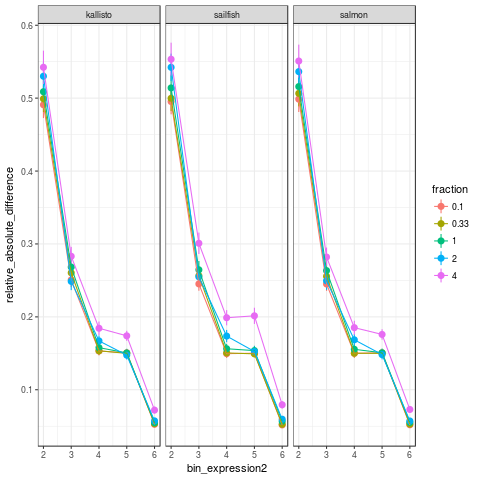

In [18]:
%%R
print(head(subsetted_final_t_df))

p = ggplot(subsetted_final_t_df[subsetted_final_t_df['bin_expression2']>1,],
           aes(bin_expression2, relative_absolute_difference)) +
stat_summary(aes(colour = fraction)) +
stat_summary(fun.y = mean, geom="line", aes(colour = fraction)) +
theme_bw() +
facet_grid(.~quantifier)

print(p)